In [34]:
import pandas as pd
import numpy as np

In [35]:
df_train_set = pd.read_csv("dataset/training-set.csv")
df_test_set = pd.read_csv("dataset/testing-set.csv")
df_train_set["type"] = 'train'
df_test_set["type"] = 'test'

df_week_expenc_feat = pd.read_csv("dataset/week_expenc_feat.csv")
df_wk_enc_feat = pd.read_csv("dataset/wk_enc_feat.csv")

df_week_expenc_feat_val = pd.read_csv("dataset/week_expenc_feat_val.csv")
df_wk_enc_feat_val = pd.read_csv("dataset/wk_enc_feat_val.csv")

df_train_set = pd.merge(df_train_set, df_week_expenc_feat_val, how='left', on='file_id')
df_test_set = pd.merge(df_test_set, df_wk_enc_feat, how='left', on='file_id')
df = pd.concat([df_train_set, df_test_set],axis=0)

print (df.shape)

(81977, 11)


In [36]:
df['enc_prod_mean'] = df['enc_prod_mean'].fillna(df['enc_prod_mean'].mean())
df['enc_cust_mean'] = df['enc_cust_mean'].fillna(df['enc_cust_mean'].mean())

df['enc_prod_min'] = df['enc_prod_min'].fillna(df['enc_prod_min'].min())
df['enc_cust_min'] = df['enc_cust_min'].fillna(df['enc_cust_min'].min())

df['enc_prod_max'] = df['enc_prod_max'].fillna(df['enc_prod_max'].max())
df['enc_cust_max'] = df['enc_cust_max'].fillna(df['enc_cust_max'].max())

df['enc_prod_std']=df['enc_prod_std'].fillna(-999.0)
df['enc_cust_std']=df['enc_cust_std'].fillna(-999.0)

In [37]:
def merge_rep(df):
    f = {
        df.columns[1]: 'mean', df.columns[2]: 'mean', df.columns[3]: 'max', df.columns[4]: 'min'
    }
    df_new = df.groupby(["file_id"]).aggregate(f).reset_index()
    df_new.columns = df.columns
    return df_new

df_cust_enc1 = pd.read_csv("dataset/cust_ec_new.csv")
df_custXprod_enc = pd.read_csv("dataset/custXprod_ec_new.csv")
df_custXprodXdate_enc = pd.read_csv("dataset/custXprodXdate_ec.csv")

df_cust_enc1 = merge_rep(df_cust_enc1)
df_custXprod_enc = merge_rep(df_custXprod_enc)
df_custXprodXdate_enc = merge_rep(df_custXprodXdate_enc)

print (df_cust_enc1.shape, df_custXprod_enc.shape, df_custXprodXdate_enc.shape)

(81894, 5) (81894, 5) (81894, 5)


In [38]:
# import label and feature coming from BC

df_garbage = pd.read_csv("dataset/garbage_info.csv")
df_FileIdOverCoustomerId = pd.read_csv("dataset/FileIdOverCoustomerId.csv")
df_file_cust_prod_ct_uct = pd.read_csv("dataset/file_cust_prod_ct_uct.csv")
df_hour = pd.read_csv("dataset/hour.csv")
df_count_interval_six = pd.read_csv("dataset/count_interval_six.csv")
df_count_min_interval_15 = pd.read_csv("dataset/count_min_interval_15.csv")
df_file_mins_count_big_ratio = pd.read_csv("dataset/file_mins_count_big_ratio.csv")
df_queryts = pd.read_csv("dataset/queryts.csv")
df_mean_enc = pd.read_csv("dataset/file_mean_enc.csv")
df_cust_enc = pd.read_csv("dataset/custXprod_enc_all_perday.csv") #_ap, _all, cust_enc_all_perday
df_prod_enc = pd.read_csv("dataset/prod_enc.csv")
df_product_cnt = pd.read_csv("dataset/product_cnt.csv")
df_hour_interval = pd.read_csv("dataset/hour_interval.csv")

df = pd.merge(df, df_file_cust_prod_ct_uct, how='left', on=["file_id"])
df = pd.merge(df, df_hour, how='left', on=["file_id"])
df = pd.merge(df, df_count_interval_six, how='left', on=["file_id"])
df = pd.merge(df, df_count_min_interval_15, how='left', on=["file_id"])
df = pd.merge(df, df_queryts, how='left', on=["file_id"])
df = pd.merge(df, df_garbage, how='left', on=["file_id"])
df = pd.merge(df, df_mean_enc, how='left', on=["file_id"])
df = pd.merge(df, df_FileIdOverCoustomerId, how='left', on=["file_id"])
df = pd.merge(df, df_cust_enc, how='left', on=["file_id"])
df = pd.merge(df, df_cust_enc1, how='left', on=["file_id"])
df = pd.merge(df, df_prod_enc, how='left', on=["file_id"])
df = pd.merge(df, df_custXprod_enc, how='left', on=["file_id"])
df = pd.merge(df, df_custXprodXdate_enc, how='left', on=["file_id"])
df = pd.merge(df, df_file_mins_count_big_ratio, how='left', on=["file_id"])
df = pd.merge(df, df_product_cnt, how='left', on=["file_id"])
df = pd.merge(df, df_hour_interval, how='left', on=["file_id"])

df = df.fillna(-999.0)
print (df.shape)
print ("number of train :", df_train_set.shape[0])
print ("number of test  :", df_test_set.shape[0])

(81977, 184)
number of train : 52559
number of test  : 29418


In [39]:
df_train = df[(df.type == 'train')&(df.date_min <= 51)].reset_index(drop=True)
df_val = df[(df.type == 'train')&(df.date_min > 51)].reset_index(drop=True)
df_test = df[(df.type == 'test')].reset_index(drop=True)

print (df_train.shape, df_val.shape, df_test.shape)

(45735, 184) (6824, 184) (29418, 184)


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import auc, roc_curve

In [41]:
def auc_f(rfc, X, y):
    pred_prob = rfc.predict_proba(X)
    pred_prob = pd.DataFrame(pred_prob, columns=["label_0", "label_1"])
    pred = np.array(pred_prob["label_1"]).reshape(y.shape[0], )

    fpr, tpr, thresholds = roc_curve(y, pred, pos_label=1)
    auc_ = auc(fpr, tpr)
    return auc_, pred

In [42]:
from matplotlib import pyplot as plt

def plot_importance(rfc):
    imp = pd.DataFrame(data = rfc.feature_importances_,
                       index = df_train.drop(col_del, axis=1).columns,
                       columns = ["important"])
    imp.plot(kind = "barh", figsize = (8, 30), alpha = 0.8)
    plt.show()

In [43]:
col_del = [
    'file_id', 'label', 'type', 'date_count', 'date_during', 'date_max', 'date_min'
]
X_train = df_train.drop(col_del, axis=1)
y_train = np.array(df_train["label"]).reshape(df_train.shape[0], )
X_val = df_val.drop(col_del, axis=1)
y_val = np.array(df_val["label"]).reshape(df_val.shape[0], )
X_test = df_test.drop(col_del, axis=1)

In [44]:
# learning rate: between 0.05 to 0.2
# min_samples_split: should be ~0.5-1% of total values.
# min_samples_leaf: small value because of imbalanced classes.
# max_depth: Should be chosen (5-8)
# max_features: "sqrt", Its a general thumb-rule to start with square root.
# subsample: 0.8

def ensemble_gbm(lr, rs):
    gbm = GradientBoostingClassifier(
        min_samples_split=50, min_samples_leaf=5, min_weight_fraction_leaf=0.0,
        max_depth=5, max_leaf_nodes=None, max_features="sqrt",
        learning_rate=lr, n_estimators=200, subsample=0.8, loss="exponential",
        init=None, random_state=rs, verbose=0, warm_start=False, presort="auto",
        criterion="friedman_mse", min_impurity_decrease=0.0, min_impurity_split=None
    )
    gbm.fit(X_train, y_train)

    auc_train, _ = auc_f(gbm, X_train, y_train)
    auc_val, pred_val = auc_f(gbm, X_val, y_val)

    print (auc_train, auc_val)    
    return pred_val, gbm

In [45]:
col_ = 0
pred = pd.DataFrame()
for i in [0.05, 0.1, 0.2]:
    for j in [100, 1000, 10000, 200, 2000, 500, 4000]:
        col_name = "p" + str(col_)
        pred_, gbm = ensemble_gbm(i, j)
        pred_ = pd.DataFrame(pred_, columns=[col_name])
        pred = pd.concat([pred, pred_], axis=1)
        col_ += 1

0.9926741509652695 0.9554919130961896
0.9926630856468018 0.9571691396491878
0.9926027349398896 0.9560695215039441
0.9925717111601673 0.9550710620504326
0.9926572897709854 0.956079560152742
0.9925272710012409 0.9556506009675714
0.992613314713205 0.9549739574284071
0.9958993054179489 0.9566563963567427
0.9960502179622411 0.9573322676921532
0.9958598331525794 0.95732531785837
0.9959573203971294 0.9558834203993066
0.9958385202759005 0.9569592932791245
0.9959246048758772 0.9584363260089808
0.9961618422372213 0.9566878636597053
0.9985060031218203 0.9564469360885564
0.9985140682823477 0.955945582801478
0.9985341545186421 0.9577370955100214
0.9985127394219312 0.9560175908015088
0.9985443151898263 0.9568677871343132
0.9984882679462624 0.9573210707377249
0.9984739724747826 0.9570973247000953


In [46]:
pred_mean = pred.mean(axis=1)
fpr, tpr, thresholds = roc_curve(y_val, pred_mean, pos_label=1)
auc(fpr, tpr)

0.9579654747701728

[[1.         0.99466873]
 [0.99466873 1.        ]]


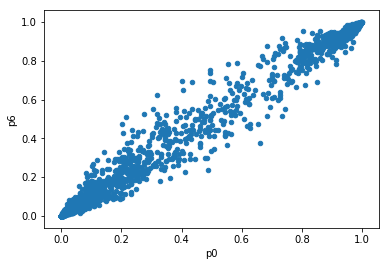

In [47]:
print (np.corrcoef(pred.p0, pred.p6))

pred.plot(kind="scatter", x="p0", y="p6")
plt.show()

### feature selection

### parameter tuning

### submit

In [48]:
def submit(rfc, X_test):
    rfc.fit(df.drop(col_del, axis=1), df["label"])
    pred_prob = rfc.predict_proba(X_test)
    pred_prob = pd.DataFrame(pred_prob, columns=["label_0", "Probability"])

    df_sub = pd.concat([df_test.file_id, pred_prob.Probability], axis = 1)
    df_sub = pd.merge(df_test_set[["file_id"]], df_sub, how = "left", on = "file_id")
    df_sub = df_sub.fillna(0)
    df_sub.columns = ["FileID", "Probability"]
    return df_sub

def testing(lr, rs):
    gbm = GradientBoostingClassifier(
        min_samples_split=50, min_samples_leaf=5, min_weight_fraction_leaf=0.0,
        max_depth=5, max_leaf_nodes=None, max_features="sqrt",
        learning_rate=lr, n_estimators=200, subsample=0.8, loss="exponential",
        init=None, random_state=rs, verbose=0, warm_start=False, presort="auto",
        criterion="friedman_mse", min_impurity_decrease=0.0, min_impurity_split=None
    )
    df_sub = submit(gbm, X_test)
    return df_sub

In [49]:
df = pd.concat([df_train, df_val], axis = 0)

In [50]:
pred = pd.DataFrame()
for i in [0.05, 0.1, 0.2]:
    for j in [100, 1000, 10000, 200, 2000, 500, 4000]:
        df_sub_ = testing(i, j)
        pred = pd.concat([pred, df_sub_[["Probability"]]], axis=1)
print (pred.shape)

(29418, 21)


In [51]:
df_sub = pd.concat([df_test[["file_id"]], pred.mean(axis=1)], axis=1)
df_sub.columns = ["FileID", "Probability"]
df_sub.to_csv("submit/sub0323.csv", index = False)